# Computer Assignment 2
# Naive Bayes
## Ali Bahari

Project Name: Computer Assignment 2 Naive Bayes

Project Goal: Use Naive Bayes to predict a book's category from it's name and description which is given in csv files.

In this assignment we are using Naive Bayes and bag of words algorithm to predict the category of a book. First of all we will do some preprocessing on the train dataset which is consisted of merging name and description of each bok, removing punctuations, removing some of the whitespaces, removing stopwords, normalization, getting the words of the sentences and finally lemmatizing them. After that we will use the preprocessed train dataset to find the needed probabilities for our algorithm and by finding them we can use them to predict the books in the test dataset this prediction is done by finding the maximum probability and setting the class(category) of that probability to be our prediction.

In [1]:
from __future__ import unicode_literals

import pandas as pd
from hazm import *
import numpy as np
import math


trainDataframe = pd.read_csv("./books_train.csv")
trainDataframe["info"] = trainDataframe["title"] + trainDataframe["description"]
trainDataframe = trainDataframe.drop(columns = ['title', 'description'])

Getting train dataset. Merging title and description and removing the title and description columns since we don't need them anymore all our processes will be done on the new merged column named info.

In [2]:
punctuation = set('''?\#$%@&^.؟؛][=*×،!-+ـ)(٪:«»<>…/_.,{};~'"|٬٫''')
whitespace = {"\t" , "\n" , "\r"}
stopWords = set(stopwords_list())


def removePunctuationWhitespaceAndGetWords(text):
    i = 0
    while(i < len(text)):
        if(text[i] in whitespace or text[i] in punctuation):
            text = text[:i] + "" + text[i+1:]
            continue
        i += 1
    return word_tokenize(text)

def removeStopWordsAndLemmatizeWords(words):
    finalWords = set()
    for word in words:
        if(word not in stopWords):
            finalWords.add(lemmatizer.lemmatize(word))
    return finalWords

def printTestCell():
    for word in trainDataframe.loc[0 , "info"]:
        print(word)

lemmatizer = Lemmatizer()
normalizer = Normalizer()
trainDataframe["info"] = trainDataframe["info"].apply(normalizer.normalize)
trainDataframe["info"] = trainDataframe["info"].apply(removePunctuationWhitespaceAndGetWords)
trainDataframe["info"] = trainDataframe["info"].apply(removeStopWordsAndLemmatizeWords)

trainDataframe["categories"] = trainDataframe["categories"].apply(normalizer.normalize)

All the other mentioned preprocesses are done here.

In [3]:
trainInfo = {"جامعه‌شناسی": {} , "کلیات اسلام": {} , "داستان کودک و نوجوانان": {} , "داستان کوتاه": {} , "مدیریت و کسب و کار": {} , "رمان": {}}

trainCounts = {"جامعه‌شناسی": 0 , "کلیات اسلام": 0 , "داستان کودک و نوجوانان": 0 , "داستان کوتاه": 0 , "مدیریت و کسب و کار": 0 , "رمان": 0}

wordsAllCategories = set()

In [4]:
def fillTrainInfo(trainInfo , words , category):
    for word in words:
        trainCounts[category] += 1
        wordsAllCategories.add(word)
        if(word not in trainInfo[category].keys()):
            trainInfo[category][word] = 1
        else:
            trainInfo[category][word] += 1
    

trainDataframe.apply(lambda row : fillTrainInfo(trainInfo , row["info"] , row["categories"]), axis = 1);

Here we finding the numbers of each word in each class. These values will be needed for calculationg probability.

In [5]:
# Now it's time to get test dataset in here
testDataframe = pd.read_csv("./books_test.csv")
testDataframe["info"] = testDataframe["title"] + testDataframe["description"]
testDataframe = testDataframe.drop(columns = ['title', 'description'])

In [6]:
lemmatizer = Lemmatizer()
normalizer = Normalizer()

testDataframe["info"] = testDataframe["info"].apply(normalizer.normalize)
testDataframe["info"] = testDataframe["info"].apply(removePunctuationWhitespaceAndGetWords)
testDataframe["info"] = testDataframe["info"].apply(removeStopWordsAndLemmatizeWords)

testDataframe["categories"] = testDataframe["categories"].apply(normalizer.normalize)

Importing test dataset and doing the same preprocesses as before.

In [7]:
def getBayesAns(trainInfo , trainCounts , testWords):
    highest_p = float("-inf"); chosenCategory = "رمان"
    for category , categoryWords in trainInfo.items():      
        p = math.log(1/6)   # 6 classes each having the same probability so 1/6
        for testWord in testWords:
            if(testWord in categoryWords.keys()):
                p += math.log(categoryWords[testWord] / trainCounts[category])
            else:
                p += float("-inf")
        
        if(p > highest_p):
            highest_p = p
            chosenCategory = category
            
    return chosenCategory


testDataframe["BayesAns"] = testDataframe.apply(lambda row : getBayesAns(trainInfo , trainCounts , row["info"]), axis = 1);

Calculating probabilities and finding the maximum probability. When we don't find the word in the class the probability will be 0 meaning that by using log the result will be -inf.

BayesAns show us the predictions without additive smoothing and BayesAnsAs show us the predictions with additive smoothing. matches shows us the validity of predictions without additive smoothing and matchesAS shows us the validity of predictions with additive smoothing

In [8]:
testDataframe["matches"] = np.where(testDataframe["categories"] == testDataframe["BayesAns"], True, False)
testDataframe["matches"].value_counts()

False    343
True     107
Name: matches, dtype: int64

This part is used for finding accuracy.

In [9]:
def getBayesAnsWithSmoothing(trainInfo , trainCounts , testWords):
    highest_p = float("-inf"); chosenCategory = ""
    alpha = 0.1
    for category , categoryWords in trainInfo.items():
        p = math.log(1/6)   # 6 classes each having the same probability so 1/6
        for testWord in testWords:
            if(testWord in categoryWords.keys()):
                p += math.log((categoryWords[testWord] + alpha) / (trainCounts[category] + alpha * len(wordsAllCategories)))
            else:
                p += math.log(alpha / (trainCounts[category] + alpha * len(wordsAllCategories) ) )
        
        if(p > highest_p):
            highest_p = p
            chosenCategory = category
            
    return chosenCategory


testDataframe["BayesAnsAS"] = testDataframe.apply(lambda row : getBayesAnsWithSmoothing(
                                                             trainInfo , trainCounts , row["info"]) , axis = 1);

Exactly the same as not having additive smoothing but here we are using the procedure explained further down the report.

In [10]:
testDataframe["matchesAS"] = np.where(testDataframe["categories"] == testDataframe["BayesAnsAS"], True, False)
testDataframe["matchesAS"].value_counts()

True     360
False     90
Name: matchesAS, dtype: int64

## Questions

Question 1:

Lemmatization which is used here is a way of getting the root of words. This procedure is very useful with verbs since we have many forms of a verb with identical root in persian. Also this procedure can be useful with noun. For nouns what we need is the main part of it meaning that we don't want the plural words or any other part of speech connected to it. Lemmatization will remove all these unnecessary parts and gives us the main part of each part of speech. This can come in handy when we want to preprocess data for text recognition.

Stemming is another way of doing such thing but it's not as useful as lemmatization. Stemming tries to remove postfix of words to generate the main parts them but sometimes there can be some mistakes or shall we say undesired outputs. Stemming won't do the same thing as lemmatization with verbs but for noun it's partially the same.

So in general the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time not all the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

Question 2:

Posterior: Probability of a word belonging to the mentioned categories (which here there are 6 categories) given the word. We can decide the category of a text or in other words a new set of words by comparing this probability for our 6 categories.

Prior: Probabilty of the category occurrence in general. This value can be calculated or simply be 1/6 meaning that we'll assign equal probability to occurrence of each category and since there are 6 categories the probability will be 1/6. Here in the code 1/6 is used.

Likelihood: It's the probability of a word occurring given the category. So it's the number of that word occurring in one of the categories divided by the number of all the words in the same category.

Evidence: Probability of the word itself which is the number of that word occurring in the dataset. Because this number is independent of the class and we are going to compare probability of the classes given the same words this number would be the same in both sides of the comparison so we can ignore it and never calculate it meaning that here we can calculate and compare everything without this value.

Question 3:

Since the report is in English, English examples are provided

The best we can do is to fight back and bring in sky high success.
The sky is beautiful today.

Here the word sky can show the need for bigrams or n-grams clearly. By using unigrams, in both of the examples the sky will mean as the blue sky above us. Although this meaning is correct for the second sentence, there's a different situation in the first sentence. In the fisrt one, sky is an adverb for the word high and simply means very. So the only way we can correctly guess the meaning of the word is by using n-grams and showing that the there words sky, high and success are dependent. In the mentioned example bigrams aren't adequate since it'll only give us sky high, we know that this is and adjective but we still don't know to what word so using 3-grams will do the trick.

Question 4:

The problem is that if a word doesn't exist in the dataset of a category, the probability of that category will be zero and since we are multiplying p by this words probability which is 0 or in another way getting log of a zero which will return -inf therefore that test data will definitely be classified in one of the other categories because of that one and only word. Since here we're using log for calculation the result will be -inf and according to the code that category certainly won't be selected.

Question 5:

Additive smoothing is a technique for smoothing categorical data. A small-sample correction will be incorporated in every probability estimate. Consequently, no probability will be zero and this really comes in handy since there can be new words in the test dataset that we haven't seen in the train dataset, this is a way of regularizing Naive Bayes. So in additive smoothing we are trying to prevent zero probability this'll be achieved by changing the way we calculate probability of each word given the class:

$p(word|class) = (word + alpha) ÷ (N + alpha*d)$

alpha is coefficient that is greater than zero and usually less than 1.
N is all words in that particular class.
d is number of possible words in all 6 categories (without the duplicates meaning that all the words are unique)

By adding alpha which is greater zero it's guaranteed that the probability for each word won't be zero and this'll prevent the mentioned problem in the project description. In the code for additive smoothing the above formula is used.

Question 6:

The bar chart below shows the wanted results.

Also since the words are in Persian there is a problem with showing in RTL but it's kinda readable. :)

In [11]:
import matplotlib.pyplot as plt
import operator

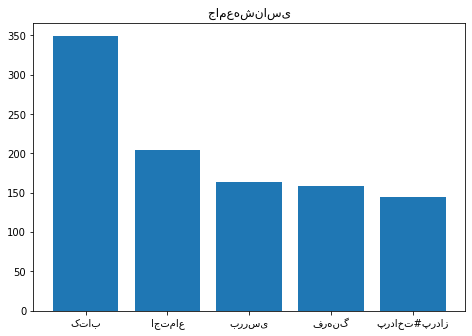

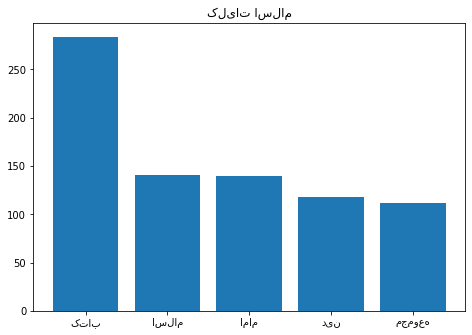

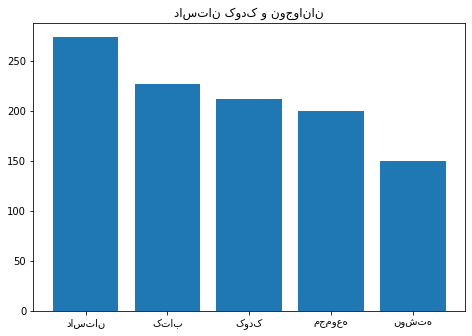

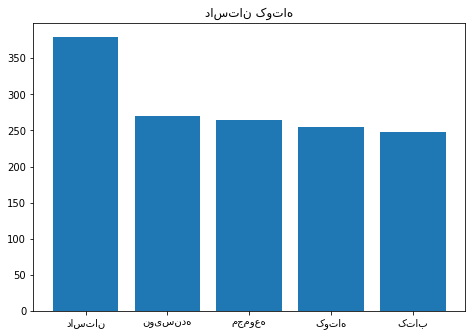

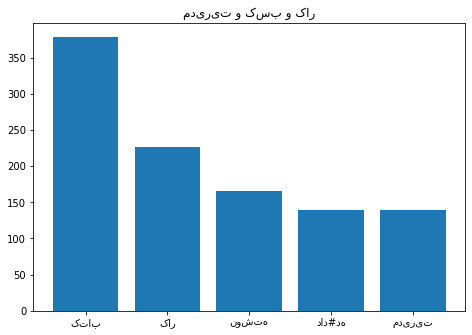

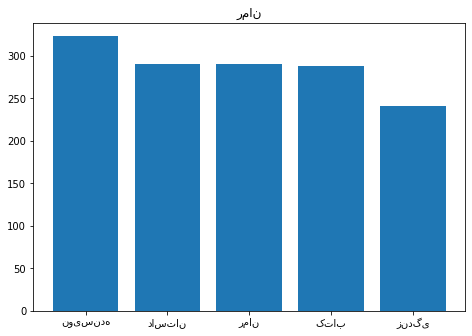

In [12]:
for category in trainInfo.keys():
    sortedTrainInfo = dict(sorted(trainInfo[category].items(), key=operator.itemgetter(1), reverse=True)[:5])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title(category)
    words = [word for word in sortedTrainInfo.keys()]
    numbers = [num for num in sortedTrainInfo.values()]
    ax.bar(words , numbers)
    plt.show()

Question 7:

Precision can be seen as a measure of exactness or quality but recall is a measure of completeness or quantity meaning high precision shows that an algorithm returned substantially more relevant results than irrelevant ones but high recall means that an algorithm returned most of the relevant results.

Consider a plumber tasked with removing a bad pipe from house. The plumber needs to remove all of the infected pipe parts since any remaining part regenerate the problem. Also the plumber must not remove OK parts since that would leave the house with damaged pipes. The plumber may be more liberal in the area of the pipe he removes to ensure he has extracted all the infected parts. This decision increases recall but reduces precision. On the other hand, the plumber may be more conservative in the parts (pipe) he removes to ensure he extracts only infected parts. This decision increases precision but reduces recall. That is to say, greater recall increases the chances of removing OK parts which is negative outcome and increases the chances of removing all infected parts which is positive outcome. Greater precision decreases the chances of removing OK parts which is positive outcome but also decreases the chances of removing all infected parts which is negative outcome. Usually, precision and recall are not discussed in isolation. Instead either values for one measure are compared for a fixed level at the other measure or both are combined into a single measure. High precision agent can only detect what it's sure is in one class and ignore others. So it will have very few objects in one class while there were many others left out of the class. This way the precision is very high because things that are detected in class were actually in that class but lots of other things were ignored.

The descriptions above shows that in this project that is similar to mentioned situation, percision and recall aren't enough to evaluate the model. These two are usually related.

Question 8:

F1 Score is needed when you want to seek a balance between Precision and Recall. F1 score is the harmonic mean of precision and recall.

The harmonic mean can be expressed as the reciprocal (inversed) of the arithmetic mean of the reciprocals of the given set of observations. Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list it tends compared to the arithmetic mean to mitigate and lessen the impact of large outliers and aggravate and make the impact of small ones more serious. So according to this information this mean is useful here.

Question 9:

A macro average will compute the metric independently for each class and then take the average hence treating all classes equally whereas a micro average will aggregate and group the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance.

micro average tells the function to compute by considering total true positives, false negatives and false positives. macro average tells the function to compute f1 for each label, and returns the average without considering the proportion for each label in the dataset. weighted average tells the function to compute f1 for each label, and returns the average considering the proportion for each label in the dataset.

Micro averaging in a multiclass setting with all labels included will produce equal precision, recall and F, while weighted averaging may produce an F-score that is not between precision and recall. Since here we have the first case then minor averaging will result in precision, recall and f being equal to accuracy.

Question 10: 

Precision for each class => number of correct predictions / all predictions of that class

recall for each class => number of correct predictions / all actual data of that class

accuracy => number of correct predictions in total / all data

With additive smoothing results are calculated first. 

جامعه‌شناسی
Precision: 72.82608695652173%  |  Recall: 89.33333333333333%  |  F1: 80.23952095808383%
___________________
رمان
Precision: 67.44186046511628%  |  Recall: 77.33333333333333%  |  F1: 72.04968944099377%
___________________
کلیات اسلام
Precision: 93.65079365079364%  |  Recall: 78.66666666666666%  |  F1: 85.5072463768116%
___________________
داستان کودک و نوجوانان
Precision: 89.04109589041096%  |  Recall: 86.66666666666667%  |  F1: 87.83783783783785%
___________________
داستان کوتاه
Precision: 70.49180327868852%  |  Recall: 57.333333333333336%  |  F1: 63.235294117647065%
___________________
مدیریت و کسب و کار
Precision: 90.66666666666666%  |  Recall: 90.66666666666666%  |  F1: 90.66666666666667%
___________________
Accuracy: 80.0%
True     360
False     90
Name: matchesAS, dtype: int64


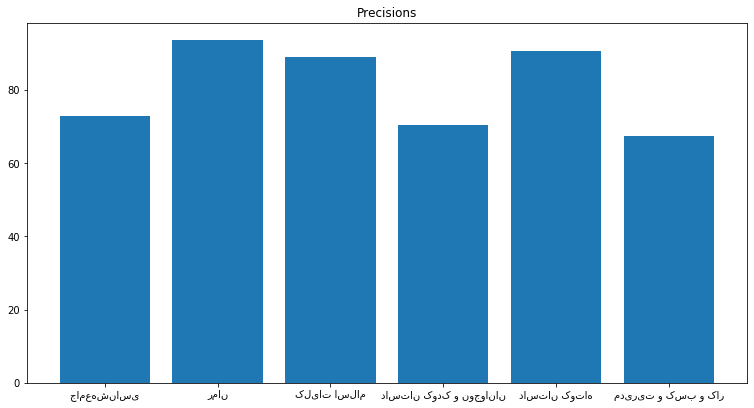

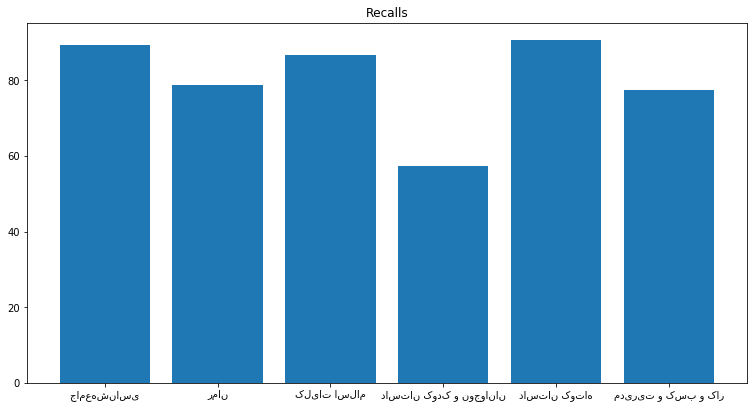

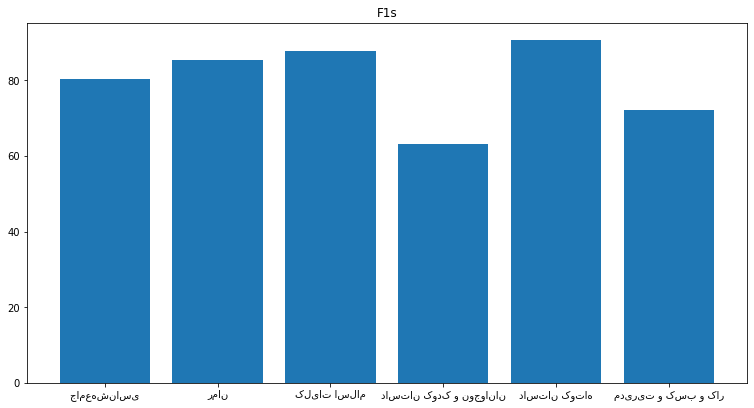

In [13]:
categoriesNames = set(testDataframe["categories"])
precisions = {"جامعه‌شناسی": 0 , "کلیات اسلام": 0 , "داستان کودک و نوجوانان": 0 , "داستان کوتاه": 0 , "مدیریت و کسب و کار": 0 , "رمان": 0}
recalls = {"جامعه‌شناسی": 0 , "کلیات اسلام": 0 , "داستان کودک و نوجوانان": 0 , "داستان کوتاه": 0 , "مدیریت و کسب و کار": 0 , "رمان": 0}
F1s = {"جامعه‌شناسی": 0 , "کلیات اسلام": 0 , "داستان کودک و نوجوانان": 0 , "داستان کوتاه": 0 , "مدیریت و کسب و کار": 0 , "رمان": 0}
numAcutalData = {"جامعه‌شناسی": 0 , "کلیات اسلام": 0 , "داستان کودک و نوجوانان": 0 , "داستان کوتاه": 0 , "مدیریت و کسب و کار": 0 , "رمان": 0}

def findPrecisionsAndRecallAS():
    for category in categoriesNames:
        correct_preds = 0; num_acutal_data = 0; num_preds = 0
        for i in range(len(testDataframe)):
            if(testDataframe.loc[i , "categories"] == category):
                num_acutal_data += 1
            if(testDataframe.loc[i , "BayesAnsAS"] == category):
                num_preds += 1
            if(testDataframe.loc[i , "categories"] == testDataframe.loc[i , "BayesAnsAS"] and
               testDataframe.loc[i , "categories"] == category):
                
                correct_preds += 1
        
        precisions[category] = (correct_preds / num_preds) * 100
        recalls[category] = (correct_preds / num_acutal_data) * 100
        F1s[category] = 2 * (precisions[category] * recalls[category]) / (precisions[category] + recalls[category])
        numAcutalData[category] = num_acutal_data

findPrecisionsAndRecallAS()


for category in categoriesNames:
    print(category)
    print("Precision: " + str(precisions[category]) + "%  |  Recall: " + str(recalls[category]) + \
          "%  |  F1: " + str(F1s[category]) + "%")
    print("___________________")
    

print("Accuracy: " + str((testDataframe["matchesAS"].value_counts()[1] / len(testDataframe)) * 100) + "%")
print(testDataframe["matchesAS"].value_counts())

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Precisions")
words = list(categoriesNames)
numbers = list(precisions.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Recalls")
words = list(categoriesNames)
numbers = list(recalls.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1s")
words = list(categoriesNames)
numbers = list(F1s.values())
ax.bar(words , numbers)
plt.show()

macro average => normal average

weighted average => each percentage is multiplied by the number of acutal data of that class

micro average => In our case all precision, recall and F1 will be equal to accuracy

Macro Average Precision: 80.68638448469964%
Macro Average Recall: 79.99999999999999%
Macro Average F1: 79.9227092330068%


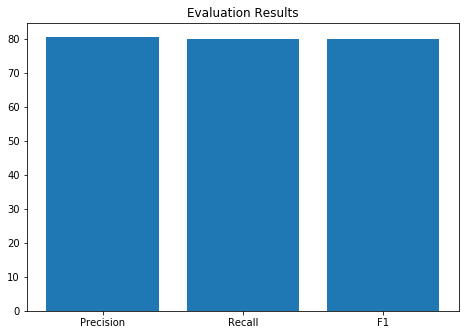

In [14]:
macroAvgPrecision = sum(precisions.values()) / len(categoriesNames)
macroAvgRecall = sum(recalls.values()) / len(categoriesNames)
macroAvgF1 = sum(F1s.values()) / len(categoriesNames)

print("Macro Average Precision: " + str(macroAvgPrecision) + "%")
print("Macro Average Recall: " + str(macroAvgRecall) + "%")
print("Macro Average F1: " + str(macroAvgF1) + "%")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [macroAvgPrecision , macroAvgRecall , macroAvgF1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 80.68638448469962%
Weighted Average Recall: 80.0%
Weighted Average F1: 79.9227092330068%


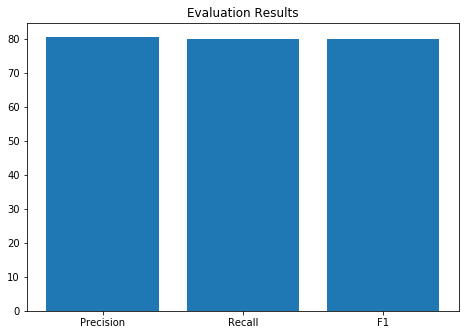

In [15]:
weightedAvgPrecision = 0; weightedAvgRecall = 0; weightedAvgF1 = 0
for category in categoriesNames:
    weightedAvgPrecision += (numAcutalData[category] * precisions[category])
    weightedAvgRecall += (numAcutalData[category] * recalls[category])
    weightedAvgF1 += (numAcutalData[category] * F1s[category])
    
weightedAvgPrecision /= len(testDataframe)
weightedAvgRecall /= len(testDataframe)
weightedAvgF1 /= len(testDataframe)

print("Weighted Average Precision: " + str(weightedAvgPrecision) + "%")
print("Weighted Average Recall: " + str(weightedAvgRecall) + "%")
print("Weighted Average F1: " + str(weightedAvgF1) + "%")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [weightedAvgPrecision , weightedAvgRecall , weightedAvgF1]
ax.bar(words , numbers)
plt.show()

Since total number of each class is equal to 75, weighted average will be basically the same as macro average.  

In [16]:
accuracy = str((testDataframe["matchesAS"].value_counts()[1] / len(testDataframe)) * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 80.0%


Now it's time for without additive smoothing. Pretty much the same as before.

جامعه‌شناسی
Precision: 50.0%  |  Recall: 1.3333333333333335%  |  F1: 2.5974025974025974%
___________________
رمان
Precision: 18.072289156626507%  |  Recall: 100.0%  |  F1: 30.612244897959183%
___________________
کلیات اسلام
Precision: 100.0%  |  Recall: 14.666666666666666%  |  F1: 25.581395348837205%
___________________
داستان کودک و نوجوانان
Precision: 89.47368421052632%  |  Recall: 22.666666666666664%  |  F1: 36.17021276595744%
___________________
داستان کوتاه
Precision: 100.0%  |  Recall: 2.666666666666667%  |  F1: 5.194805194805195%
___________________
مدیریت و کسب و کار
Precision: 100.0%  |  Recall: 1.3333333333333335%  |  F1: 2.6315789473684212%
___________________
Accuracy: 23.77777777777778%
False    343
True     107
Name: matches, dtype: int64


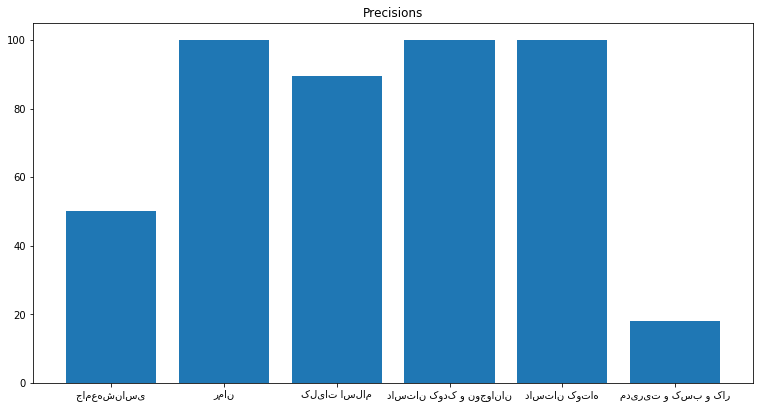

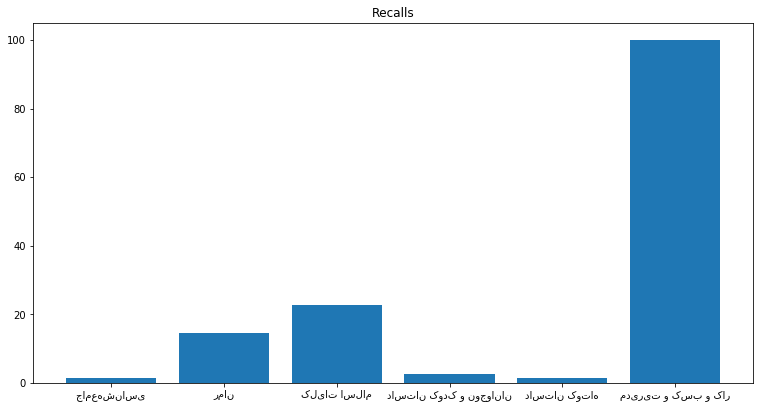

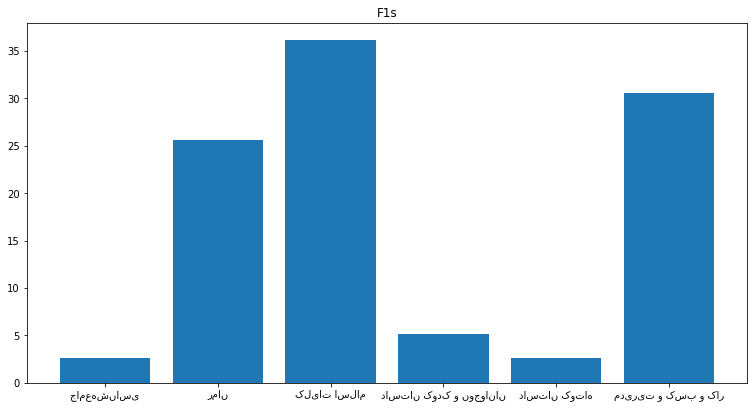

In [17]:
def findPrecisionsAndRecall():
    for category in categoriesNames:
        correct_preds = 0; num_acutal_data = 0; num_preds = 0
        for i in range(len(testDataframe)):
            if(testDataframe.loc[i , "categories"] == category):
                num_acutal_data += 1
            if(testDataframe.loc[i , "BayesAns"] == category):
                num_preds += 1
            if(testDataframe.loc[i , "categories"] == testDataframe.loc[i , "BayesAns"] and
               testDataframe.loc[i , "categories"] == category):
                
                correct_preds += 1
        
        precisions[category] = (correct_preds / num_preds) * 100
        recalls[category] = (correct_preds / num_acutal_data) * 100
        F1s[category] = 2 * (precisions[category] * recalls[category]) / (precisions[category] + recalls[category])
        numAcutalData[category] = num_acutal_data

findPrecisionsAndRecall()

for category in categoriesNames:
    print(category)
    print("Precision: " + str(precisions[category]) + "%  |  Recall: " + str(recalls[category]) + \
          "%  |  F1: " + str(F1s[category]) + "%")
    print("___________________")

print("Accuracy: " + str((testDataframe["matches"].value_counts()[1] / len(testDataframe)) * 100) + "%")
print(testDataframe["matches"].value_counts())

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Precisions")
words = list(categoriesNames)
numbers = list(precisions.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Recalls")
words = list(categoriesNames)
numbers = list(recalls.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1s")
words = list(categoriesNames)
numbers = list(F1s.values())
ax.bar(words , numbers)
plt.show()

Macro Average Precision: 76.2576622278588%
Macro Average Recall: 23.777777777777775%
Macro Average F1: 17.13127329205501%


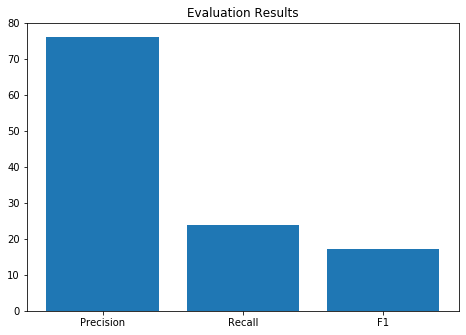

In [18]:
macroAvgPrecision = sum(precisions.values()) / len(categoriesNames)
macroAvgRecall = sum(recalls.values()) / len(categoriesNames)
macroAvgF1 = sum(F1s.values()) / len(categoriesNames)

print("Macro Average Precision: " + str(macroAvgPrecision) + "%")
print("Macro Average Recall: " + str(macroAvgRecall) + "%")
print("Macro Average F1: " + str(macroAvgF1) + "%")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [macroAvgPrecision , macroAvgRecall , macroAvgF1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 76.2576622278588%
Weighted Average Recall: 23.77777777777778%
Weighted Average F1: 17.131273292055006%


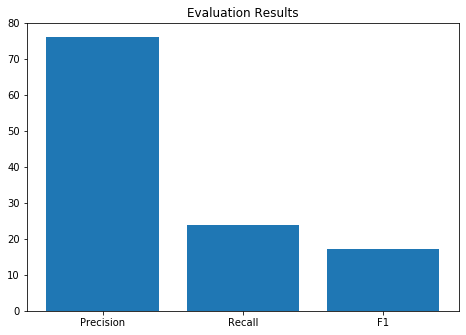

In [19]:
weightedAvgPrecision = 0; weightedAvgRecall = 0; weightedAvgF1 = 0
for category in categoriesNames:
    weightedAvgPrecision += (numAcutalData[category] * precisions[category])
    weightedAvgRecall += (numAcutalData[category] * recalls[category])
    weightedAvgF1 += (numAcutalData[category] * F1s[category])
    
weightedAvgPrecision /= len(testDataframe)
weightedAvgRecall /= len(testDataframe)
weightedAvgF1 /= len(testDataframe)

print("Weighted Average Precision: " + str(weightedAvgPrecision) + "%")
print("Weighted Average Recall: " + str(weightedAvgRecall) + "%")
print("Weighted Average F1: " + str(weightedAvgF1) + "%")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [weightedAvgPrecision , weightedAvgRecall , weightedAvgF1]
ax.bar(words , numbers)
plt.show()

In [20]:
accuracy = str((testDataframe["matches"].value_counts()[1] / len(testDataframe)) * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 23.77777777777778%


Question 11:

The numbers seem to be logical. Since without additive smoothing we have the mentioned problem with 0, or if we're using log -inf, probability there would be low accuracy. But by using additive smoothing we got rid of that problem so we would have much higher number in evaluation. Precision values in the case of not having additive smoothing clearly shows the mentioned notes previously that having higher precision doesn't simply mean good modeling. Also we're looking for the highest possible precision and recall although they have reversed relation but in case of not having additive smoothing we clearly see that precision is high but recall is much lower so we understand that the modeling isn't great. Taking a look at case of having additive smothing, we can see that all three evalutation results are not only high but also they are close to each other that is a clear sign of a nice model.

In [21]:
print(testDataframe.loc[0 , "info"])
print("Actual Data: " + testDataframe.loc[0 , "categories"])
print("Predicted Data: " + testDataframe.loc[0 , "BayesAnsAS"])
print("________________________")
print(testDataframe.loc[5 , "info"])
print("Actual Data: " + testDataframe.loc[5 , "categories"])
print("Predicted Data: " + testDataframe.loc[5 , "BayesAnsAS"])
print("________________________")
print(testDataframe.loc[12 , "info"])
print("Actual Data: " + testDataframe.loc[12 , "categories"])
print("Predicted Data: " + testDataframe.loc[12 , "BayesAnsAS"])
print("________________________")
print(testDataframe.loc[20 , "info"])
print("Actual Data: " + testDataframe.loc[20 , "categories"])
print("Predicted Data: " + testDataframe.loc[20 , "BayesAnsAS"])
print("________________________")
print(testDataframe.loc[23 , "info"])
print("Actual Data: " + testDataframe.loc[23 , "categories"])
print("Predicted Data: " + testDataframe.loc[23 , "BayesAnsAS"])

{'دلیل', 'گذشته', 'ساحت', 'محض', 'طولانی\u200cمدت', 'زیسته', 'متن', 'روایت', 'برمی\u200cگرداندم', 'گرایش', 'بود#باش', 'وسط', 'خود', 'روز', 'شهر', 'پیشکش', 'برگ', 'سخنران', 'آن\u200cجا', 'زندگی', 'هفتم', 'ترجیع\u200cبند', 'زل', 'شانزده', 'حیاط', 'واقعی', 'دهه', 'سر', 'دست', 'فاخر', 'محدود', 'نسل', 'عرب\u200cزبان', 'سخت', 'زبان', 'آن\u200cقدر', 'مجالس', 'خانواده', 'عزادار', 'دلهره', 'نامانوس', 'نردبان', 'منحصر', 'شیفتگی', 'عرب', 'امروز', 'نو', '۶۱', 'گزارش', 'پهنا', 'مرشدزاده', 'توصیف', 'پیچیده', 'فراز', 'تابستان', 'دقیق', 'رفت#رو', 'روبه\u200cرو', 'پایه', 'چکش', 'وصله', 'لحن', 'مداوم', 'معنا', 'شوم', 'صحبت', 'تپه', 'کمتر', 'سیم', 'همه', 'اشک', 'کآشوب', 'نویسندگان', 'حضور', 'نشست#نشین', 'تمام\u200cنشدنی', 'امام', 'فهمید#فهم', 'ابوذیه\u200cهای', 'محرم', 'داد#ده', 'دوره', 'هجری', 'پدر', 'خوزستان', 'پیش', 'سال', 'روزمره', 'کاشت#کار', 'تار', 'قرار', 'گوشه', 'دایره', 'تو', 'غریب', 'گفت\u200cوگوی\u200cهای', 'دل', 'اثر', 'غبیشاوی', 'ریخت#ریز', 'میخ', 'ذره', 'تعطیلات', 'مجموعه', 'کرد#کن', 'ساختا

Question 12:

Since we're using Naive Bayes we know it's naive meaning that it assumes the features are independent, the probabilities are incorrect if this assumption is not correct. Naive Bayes is also known as a bad estimator so the probability outputs are not to be taken too seriously. We are not looking at the text as a whole but instead we break the text get some info out of it and do calculations but breaking the text and not looking at it as whole will remove the relations so we'll lose some useful info. Finding the relations and adding it to our info will provide us with more evidence and so this can help us predict better.

Since we are analyzing texts here the input features are dependent, and the target depends on some higher order structure hidden in the features.

### References

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2